# **DATA PREPROPRESSING**

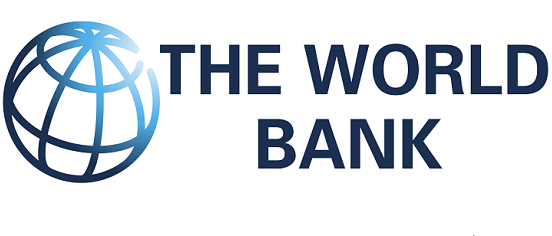

CARPETAS CON DATA DE INPUT Y OUTPUT: [Link de drive](https://drive.google.com/drive/folders/13_nqTCZV86saa2ogrwlVDtK8ZmPEYxFj?usp=sharing)

#### Unión de diferentes base de datos provenientes del World Bank, con el objetivo de generar diferentes graficos en base a la comparación de indicadores seleccionados

### Fuente de datos:
Topic https://data.worldbank.org/topic/climate-change

CO2 (kt) https://data.worldbank.org/indicator/EN.ATM.CO2E.KT

Population (7mM) https://data.worldbank.org/indicator/SP.POP.TOTL

Electric power consumption (kWh per capita) https://data.worldbank.org/indicator/EG.USE.ELEC.KH.PC


## Importamos librerías necesarias

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import missingno as ms
warnings.filterwarnings('ignore')

## Cargamos la unidad drive con la base de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/DATA/WorldBankData'
PATH = '/content/drive/MyDrive/DATA/WorldBankData'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/DATA/WorldBankData


## Cargamos los dataframe

In [ ]:
# Listamos los archivos a usar desde la unidad drive
filename = []
for filenames in os.listdir(PATH):
  if filenames.endswith('csv'):
     filename.append(filenames)
filename

['GlobalLandTemperaturesByCountry.csv',
 'API_EG.ELC.COAL.ZS_DS2_en_csv_v2_3756966.csv',
 'API_SP.POP.TOTL_DS2_en_csv_v2_3731322.csv',
 'API_EG.USE.ELEC.KH.PC_DS2_en_csv_v2_3733258.csv',
 'API_EG.USE.CRNW.ZS_DS2_en_csv_v2_3760735.csv',
 'API_EG.ELC.NUCL.ZS_DS2_en_csv_v2_3735565.csv',
 'API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_3731807.csv',
 'API_EG.USE.COMM.CL.ZS_DS2_en_csv_v2_3757982.csv',
 'API_EG.ELC.FOSL.ZS_DS2_en_csv_v2_3756199.csv',
 'API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3830791.csv']

## Cargamos la metadata

In [ ]:
PATH_metadata = PATH + "/metadata"
metadata = []
for metadat in os.listdir(PATH_metadata):
  if metadat.startswith('Metadata_Indicator'):
     metadata.append(metadat)
!pwd
df_metadat = {}
for meta in metadata:
    globals()["df_"+str(meta[30:34])] = pd.read_csv("/content/drive/MyDrive/DATA/WorldBankData/metadata/"+ str(meta))
    df_metadat[f"df_{str(meta[30:34])}"] = globals()["df_"+str(meta[30:34])]

/content/drive/MyDrive/DATA/WorldBankData


In [ ]:
df_metadat.keys()

dict_keys(['df_TOTL', 'df_CRNW', 'df_NUCL', 'df_ACCS', 'df_CO2E', 'df_FOSL', 'df_COMM', 'df_AGRI', 'df_ELEC', 'df_COAL'])

In [ ]:
pd.set_option('display.max_colwidth', 5000)
df_metadata = pd.DataFrame()
for df in df_metadat.keys():
    df_metadata[df] = df_metadat[df]['SOURCE_NOTE']

In [ ]:
df_meta = df_metadata.T

In [ ]:
  #  Creamos dataframes con los archivos cargados
df_names = {}
for file in filename:
    print(file[11:15])#
    if str(file[11:15]) == 'empe':
       globals()["df_"+str(file[11:15])] = pd.read_csv(file)
    else:
      globals()["df_"+str(file[11:15])] = pd.read_csv(file, header=2)
  
    df_names[f"df_{str(file[11:15])}"] = globals()["df_"+str(file[11:15])]

empe
COAL
TOTL
ELEC
CRNW
NUCL
ACCS
COMM
FOSL
CO2E


In [ ]:
# Leemos las columnas de cada dataframe
for name in df_names.keys():
    print(name)
    print(df_names[name].columns)

df_empe
Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')
df_COAL
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')
df_TOTL
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977

## Hago un melt a todos los df

In [ ]:
def melt_format(df, col):
  cols = ['Country Name','Country Code'] + list(map(str,range(1971,2018)))
  return df.loc[:,cols].melt(id_vars=['Country Name','Country Code']).rename(
      columns={'variable':'date',
              'Country Name':'Country',
              'Country Code':'Code',
              'value':col})

In [ ]:
for df in df_names.keys():
    if df != 'df_empe':
       df_names[df] = melt_format(df_names[df], col=str(df[3:7]))

## Damos formato al df_empe (temperatura por país)

In [ ]:
df_names['df_empe']['year'] = pd.to_datetime(df_names['df_empe']['dt'])

In [ ]:
idx = df_names["df_empe"]['year'] > pd.to_datetime('1970-01-01')
df_names["df_empe"] = df_names["df_empe"][idx]

In [ ]:
df_names['df_empe'] = df_names['df_empe'].groupby(['Country',
                 pd.Grouper(key='year', freq='1Y')                 
]).agg({'AverageTemperature':[np.mean,np.median]})

## Ploteamos la variación de la temperatura en Perú y coparamos con otros países

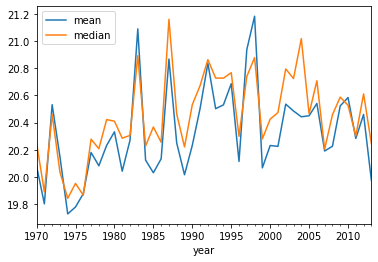

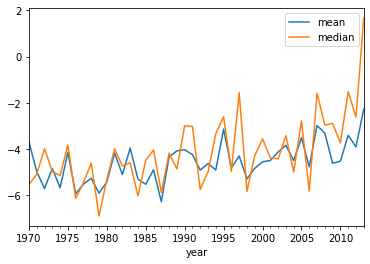

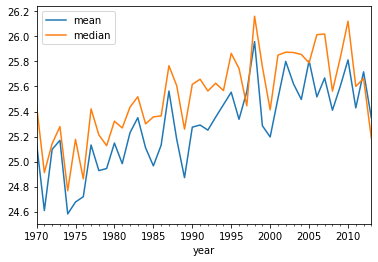

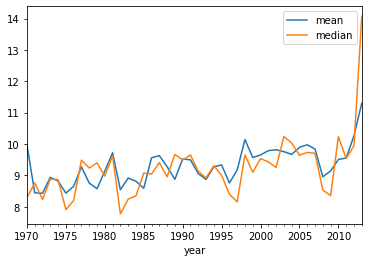

In [ ]:
df_names['df_empe'].xs("Peru")['AverageTemperature'].plot()
df_names['df_empe'].xs("Russia")['AverageTemperature'].plot()
df_names['df_empe'].xs("Brazil")['AverageTemperature'].plot()
df_names['df_empe'].xs("United States")['AverageTemperature'].plot()

In [ ]:
df_names['df_empe'] = df_names['df_empe']['AverageTemperature'][['median']].reset_index()

In [ ]:
df_names['df_empe'].rename(columns={'median':'temperature'}, inplace=True)

In [ ]:
df_names.keys()

dict_keys(['df_empe', 'df_COAL', 'df_TOTL', 'df_ELEC', 'df_CRNW', 'df_NUCL', 'df_ACCS', 'df_COMM', 'df_FOSL', 'df_CO2E'])

In [ ]:
#df_names['df_COAL'].rename(columns={'COA':'Carbon'})
#df_names['df_TOTL'].rename(columns={'TOT':'Population'})
#df_names['df_ELEC'].rename(columns={'ELE':'Electricidad Power'})
#df_names['df_CRNW'].rename(columns={'CRN':'Combustibles Renovables'})
#df_names['df_NUCL'].rename(columns={'NUC':'Electricidad Nuclear'})
#df_names['df_ACCS'].rename(columns={'COA':'Acceso Electricidad'})
#df_names['df_COMM'].rename(columns={'COM':'Nuclear Energy'})
#df_names['df_FOSL'].rename(columns={'FOS':'Electricidad fosiles'})
#df_names['df_CO2E'].rename(columns={'CO2':'CO2 Emision'})
df_names['df_empe']['year'] = df_names['df_empe']['year'].dt.year

In [ ]:
df_names['df_empe'].rename(columns={'year':'date'}, inplace=True)

In [ ]:
df_names['df_empe'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      10692 non-null  object 
 1   date         10692 non-null  int64  
 2   temperature  10648 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 250.7+ KB


In [ ]:
def object_to_float(df):
  return df['date'].astype(int)

In [ ]:
for df in df_names.keys():
    if df != 'df_empe':
       df_names[df]['date'] = object_to_float(df_names[df])

In [ ]:
def merge_df(df1,df2):
    return pd.merge(df1,
                    df2, on = ['Country', "Code", 'date'], how = 'inner')

In [ ]:
for df in df_names.keys(): 
    print(df_names[df].columns)

Index(['Country', 'date', 'temperature'], dtype='object')
Index(['Country', 'Code', 'date', 'COAL'], dtype='object')
Index(['Country', 'Code', 'date', 'TOTL'], dtype='object')
Index(['Country', 'Code', 'date', 'ELEC'], dtype='object')
Index(['Country', 'Code', 'date', 'CRNW'], dtype='object')
Index(['Country', 'Code', 'date', 'NUCL'], dtype='object')
Index(['Country', 'Code', 'date', 'ACCS'], dtype='object')
Index(['Country', 'Code', 'date', 'COMM'], dtype='object')
Index(['Country', 'Code', 'date', 'FOSL'], dtype='object')
Index(['Country', 'Code', 'date', 'CO2E'], dtype='object')


In [ ]:
df_merge = pd.merge(df_names['df_empe'][['Country','temperature','date']],
                    df_names['df_TOTL'], on = ['Country','date'], how = 'inner')

In [ ]:
for df in df_names.keys():
    if df == 'df_empe':
       print(df)   
    elif df == "df_TOTL": 
       print(df)
    else:
        df_merge= merge_df(df_merge , df_names[df])

df_empe
df_TOTL


In [ ]:
df_merge.columns

Index(['Country', 'temperature', 'date', 'Code', 'TOTL', 'COAL', 'ELEC',
       'CRNW', 'NUCL', 'ACCS', 'COMM', 'FOSL', 'CO2E'],
      dtype='object')

In [ ]:
df_meta

,0
df_TOTL,"Total population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship. The values shown are midyear estimates."
df_CRNW,"Combustible renewables and waste comprise solid biomass, liquid biomass, biogas, industrial waste, and municipal waste, measured as a percentage of total energy use."
df_NUCL,Sources of electricity refer to the inputs used to generate electricity. Nuclear power refers to electricity produced by nuclear power plants.
df_ACCS,"Access to electricity, urban is the percentage of urban population with access to electricity."
df_CO2E,"Carbon dioxide emissions are those stemming from the burning of fossil fuels and the manufacture of cement. They include carbon dioxide produced during consumption of solid, liquid, and gas fuels and gas flaring."
df_FOSL,"Sources of electricity refer to the inputs used to generate electricity. Oil refers to crude oil and petroleum products. Gas refers to natural gas but excludes natural gas liquids. Coal refers to all coal and brown coal, both primary (including hard coal and lignite-brown coal) and derived fuels (including patent fuel, coke oven coke, gas coke, coke oven gas, and blast furnace gas). Peat is also included in this category."
df_COMM,"Clean energy is noncarbohydrate energy that does not produce carbon dioxide when generated. It includes hydropower and nuclear, geothermal, and solar power, among others."
df_AGRI,"Agricultural land refers to the share of land area that is arable, under permanent crops, and under permanent pastures. Arable land includes land defined by the FAO as land under temporary crops (double-cropped areas are counted once), temporary meadows for mowing or for pasture, land under market or kitchen gardens, and land temporarily fallow. Land abandoned as a result of shifting cultivation is excluded. Land under permanent crops is land cultivated with crops that occupy the land for long periods and need not be replanted after each harvest, such as cocoa, coffee, and rubber. This category includes land under flowering shrubs, fruit trees, nut trees, and vines, but excludes land under trees grown for wood or timber. Permanent pasture is land used for five or more years for forage, including natural and cultivated crops."
df_ELEC,"Electric power consumption measures the production of power plants and combined heat and power plants less transmission, distribution, and transformation losses and own use by heat and power plants."
df_COAL,"Sources of electricity refer to the inputs used to generate electricity. Coal refers to all coal and brown coal, both primary (including hard coal and lignite-brown coal) and derived fuels (including patent fuel, coke oven coke, gas coke, coke oven gas, and blast furnace gas). Peat is also included in this category."


In [ ]:
df_merge[df_merge['Country'].isin(['Peru'])]

,Country,temperature,date,Code,TOTL,COAL,ELEC,CRNW,NUCL,ACCS,COMM,FOSL,CO2E
5332,Peru,19.8915,1971,PER,13836365.0,0.000000,390.637281,37.762788,0.0,NaN,4.038031,24.164006,18613.692
5333,Peru,20.4605,1972,PER,14221954.0,0.000000,408.593643,38.049152,0.0,NaN,4.177393,25.858779,18173.652
5334,Peru,20.0375,1973,PER,14615847.0,0.000000,411.950125,36.882946,0.0,NaN,4.312134,24.939940,19757.796
5335,Peru,19.8440,1974,PER,15017060.0,0.000000,428.046502,35.320571,0.0,NaN,4.458168,24.656405,21360.275
5336,Peru,19.9535,1975,PER,15424745.0,0.000000,436.247082,33.384751,0.0,NaN,4.540407,23.406814,21965.330
5337,Peru,19.8670,1976,PER,15838568.0,0.000000,444.042669,32.995320,0.0,NaN,4.737230,23.724103,22442.040
5338,Peru,20.2785,1977,PER,16258323.0,0.000000,471.881387,32.189856,0.0,NaN,4.754649,27.339130,23340.455
5339,Peru,20.2085,1978,PER,16683451.0,0.000000,465.371343,33.201846,0.0,NaN,5.034300,26.894112,22460.375
5340,Peru,20.4225,1979,PER,17113393.0,0.000000,475.475553,33.089834,0.0,NaN,5.468782,25.885147,22273.358
5341,Peru,20.4105,1980,PER,17547612.0,0.000000,497.446604,30.506316,0.0,NaN,5.355065,29.269265,24121.526


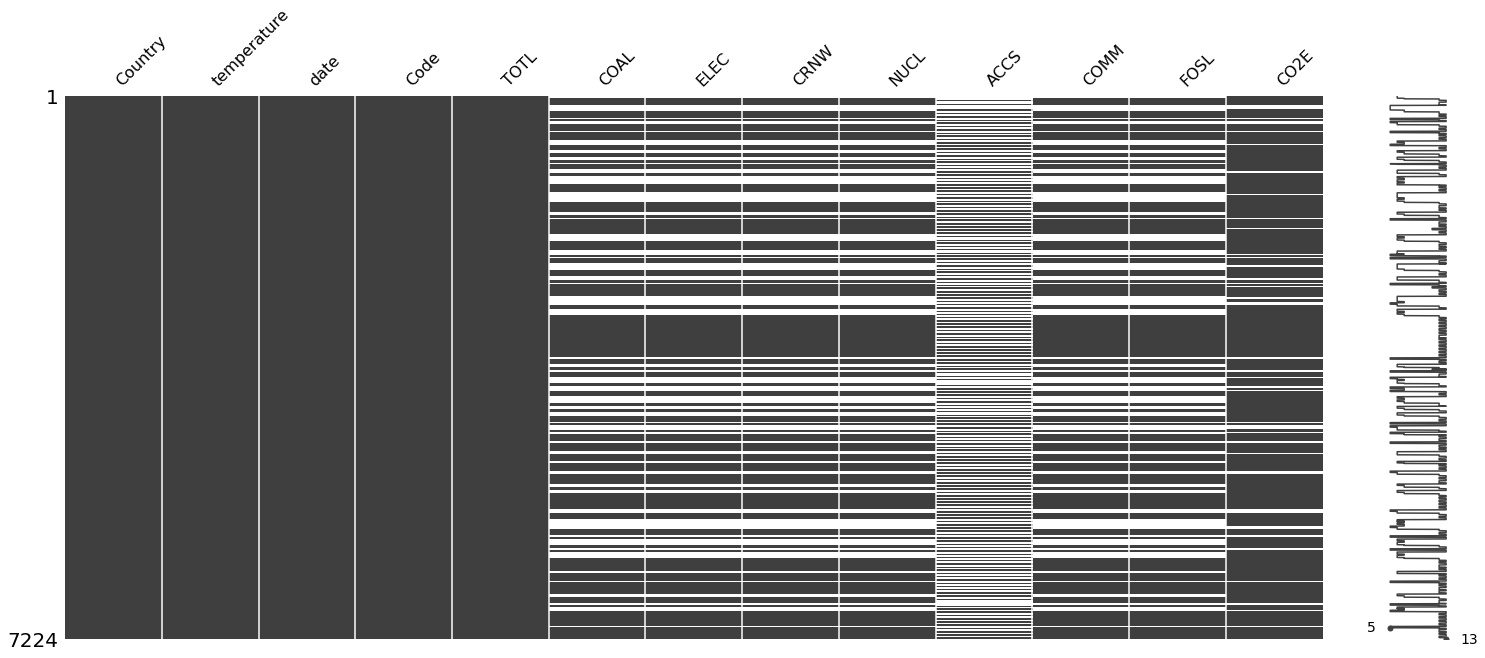

In [ ]:
ms.matrix(df_merge)

In [ ]:
for columns in df_merge:
    print(columns, df_merge[columns].isnull().sum())

Country 0
temperature 0
date 0
Code 0
TOTL 5
COAL 2551
ELEC 2552
CRNW 2549
NUCL 2551
ACCS 3842
COMM 2549
FOSL 2551
CO2E 899


In [ ]:
df_merge.drop('ACCS', axis= 'columns', inplace = True)

## Ploteo de la data referente a Perú para probar los datos

Text(0.5, 1.0, 'Perú Co2')

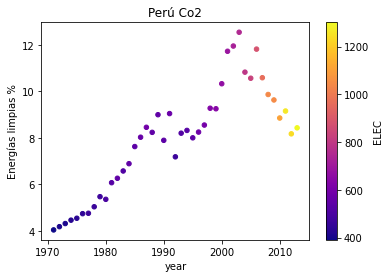

In [ ]:
fig, ax = plt.subplots()
df_merge[df_merge['Country'].isin(["Peru"])].plot.scatter( x='date', y= "COMM", c='ELEC', cmap='plasma',xlabel= 'year',ylabel='Energías limpias %',ax=ax)
plt.title("Perú Co2")

In [ ]:
df_merge = df_merge.dropna()

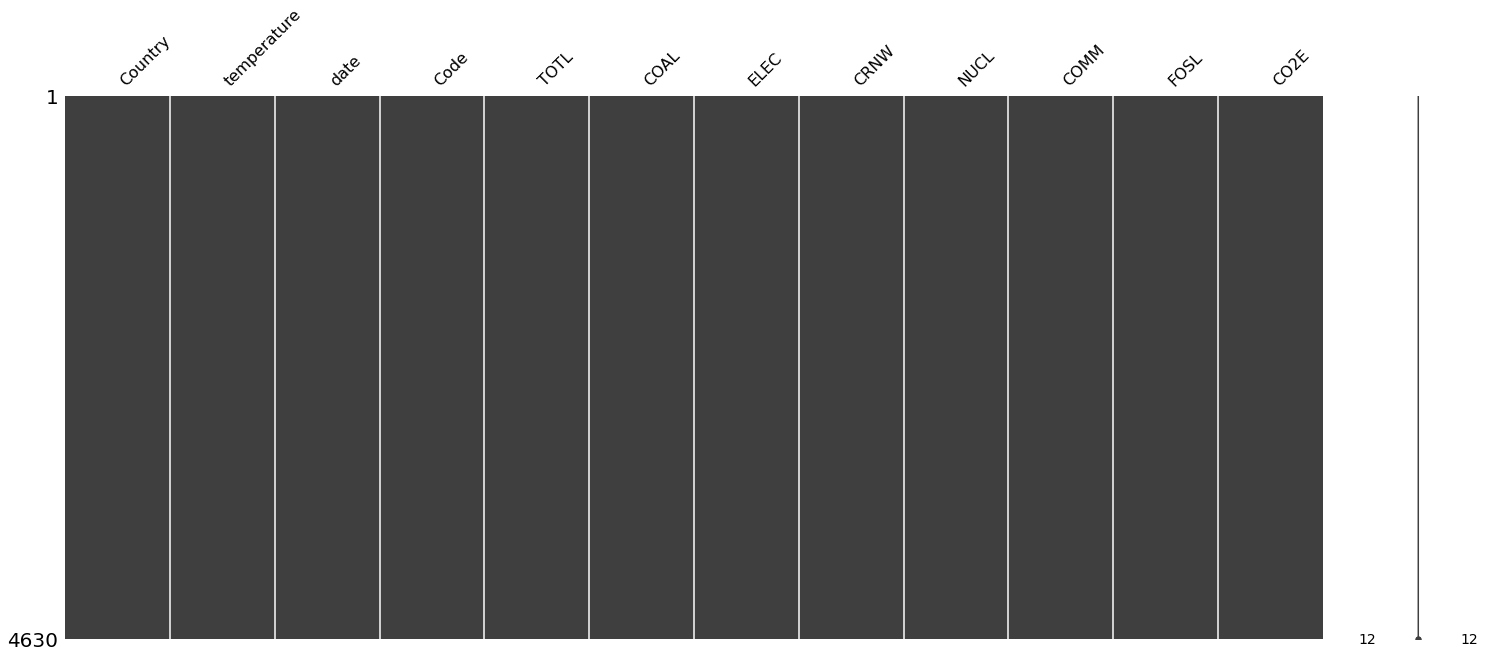

In [ ]:
ms.matrix(df_merge)

Text(0.5, 1.0, 'Perú Co2')

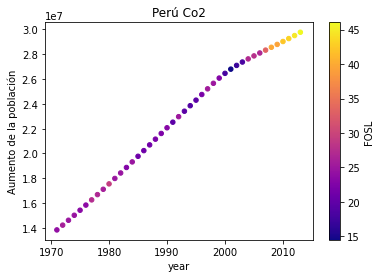

In [ ]:
fig, ax = plt.subplots()
df_merge[df_merge['Country'].isin(["Peru"])].plot.scatter( x='date', y= "TOTL", c='FOSL', cmap='plasma',xlabel= 'year',ylabel='Aumento de la población',ax=ax)
plt.title("Perú Co2")

In [ ]:
df_merge.to_csv('output_pre/data_merged.csv')
df_metadata.to_csv('output_pre/metadata.csv')